### Code generation routine

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction
import time

import pennylane as qml


ModuleNotFoundError: No module named 'pennylane'

Encrypt and decrypt functions

In [4]:
def create_keys(p, q):
    
    N=p*q
    Theta=(p-1)*(q-1)
    
    gcd=0
    e=1
    while gcd!=1:
       e+=1
       gcd=np.gcd(e,Theta) 
       # it searchs for a number that is coprime with Theta
           
    resto=0
    d=0
    while resto!=1:
        d+=1
        resto = d*e % Theta
        # it searchs for a number d that satisfies the equation d*e mod Theta = 1
        
    return (e,d,N)

print("e, d, N = ", create_keys(9803,9629))


e, d, N =  (3, 62915771, 94393087)


In [2]:
def encode(e, N, message):
    
    encoded_message = [ord(char)**e % N for char in message]
    # ord(char) returns the ASCII code of the character char
    # encoded_message is a list of integers (the encoded message in ASCII code)
    return encoded_message

def decode(d,N, code):
    
    message = [chr(character**d % N) for character in code]    
    # chr(character) returns the character with ASCII code equal to character
    # message is a list of characters (the decoded message)
    return ''.join(message)


Now we generate two lists with prime numbers, and we will use it to generate the keys, encode a message, and then decode it.

In [5]:
import random
import sympy

P=[]
Q=[]

for i in range(10):
    P.append(sympy.randprime(1, 100))
    Q.append(sympy.randprime(1, 100))


print("List p:", P)
print("List q:", Q)

for p in P:
    for q in Q:
        e,d,N=create_keys(p,q)
        message = encode(e,N,"hola")
        print("Encoded message: ", message)
        print("Decoded message: ", decode(d,N,message))

List p: [23, 83, 47, 19, 73, 53, 97, 31, 37, 53]
List q: [37, 83, 89, 97, 53, 11, 17, 29, 29, 41]
Encoded message:  [731, 333, 719, 526]
Decoded message:  hola
Encoded message:  [463, 787, 1681, 171]
Decoded message:  hola
Encoded message:  [1061, 235, 807, 1758]
Decoded message:  hola
Encoded message:  [317, 1414, 1777, 388]
Decoded message:  hola
Encoded message:  [946, 1132, 485, 861]
Decoded message:  hola
Encoded message:  [26, 166, 25, 102]
Decoded message:  hola
Encoded message:  [348, 304, 301, 79]
Decoded message:  hola
Encoded message:  [302, 281, 416, 217]
Decoded message:  hola
Encoded message:  [302, 281, 416, 217]
Decoded message:  hola
Encoded message:  [808, 281, 807, 792]
Decoded message:  hola
Encoded message:  [916, 1480, 1422, 1229]
Decoded message:  hola
Encoded message:  [1957, 3609, 5914, 3325]
Decoded message:  ͓᠚ชх
Encoded message:  [2040, 1036, 3922, 4072]
Decoded message:  hola
Encoded message:  [2742, 7622, 4493, 6790]
Decoded message:  hola
Encoded message:

In [6]:
p = 9803
q = 9629

In [7]:
def classical_factoring(N):    

        f=2
        factors=[]
        while N > 1:   
            if N % f == 0:      
                factors.append(f)
                N //= f    
            else:            
                f += 1 
        # returns a list of prime factors of N
        return np.array(factors)
    
print("Factors of 15: ", classical_factoring(p*q))
print("Factors of 2*3*5*7: ", classical_factoring(2*3*5*7))

Factors of 15:  [9629 9803]
Factors of 2*3*5*7:  [2 3 5 7]


### Running time of factoring numbers

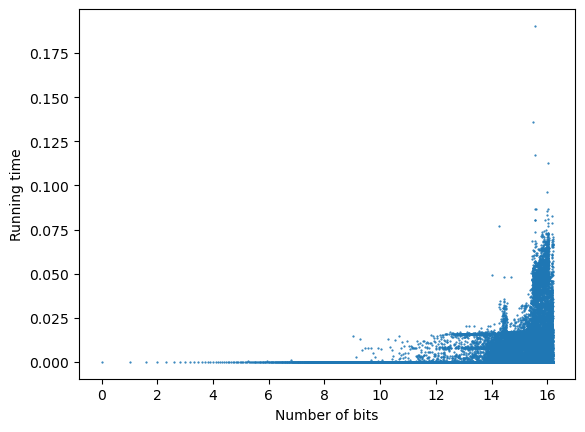

In [11]:
numbers=np.arange(1.,75000.)
running_time=np.zeros(len(numbers))

n_bits=np.log2(numbers)

for i in range(len(numbers)):
    
    start = time.time()
    factors=classical_factoring(numbers[i])
    end = time.time()
    
    running_time[i]=end-start
    
plt.scatter(n_bits, running_time, s = 0.3)
plt.xlabel('Number of bits')
plt.ylabel('Running time')
plt.show()

### Quantum functions

In [12]:
estimation_wires = 8
target_wires = 6

def get_state(a, N, target_wires, estimation_wires):
        
    # a (int): Random guess
    # N (int): Number to factorize
        
    vec = np.zeros( 2**(target_wires+estimation_wires) )
    
    #  |i>|x^i mod (N)>
    for i in range(2**estimation_wires):
        #  |j>
        s1 = np.binary_repr(i, estimation_wires) # return the binary representation of i in estimation_wires bits
        # |a^i mod (N)> 
        s2 = np.binary_repr(a**i % N, target_wires)
    
        # Set state       
        vec[int(s2+s1,2)] = 1 # convert the binary string s2+s1 to an integer in base 2
        
    return vec/np.linalg.norm(vec)


def get_period(a,N):
    
    dev = qml.device('default.qubit',shots= 50, wires=estimation_wires+target_wires)
    
    
    @qml.qnode(dev)
    def circuit(a,N):
        #STATE PREPARATION
        state = get_state(a,N,target_wires,estimation_wires)
        qml.QubitStateVector(state, wires=range(estimation_wires+target_wires))      
        # QFT^+
        qml.adjoint(qml.QFT(wires=range(estimation_wires)))
        
        return qml.sample(wires=range(estimation_wires))
    
    # Outcomes
    phases = []
    periods = []
    
    result = circuit(a,N)
    
    # Binary output to decimal
    for output in result:
        binary = "".join([str(b) for b in output])
        phases.append(int(binary,2)/2**estimation_wires)
    
    # Denominator for each phase
    for phase in phases:
        fraction = Fraction(phase).limit_denominator(N)
        # Possibles r
        for i in range(1,6):
            periods.append(fraction.denominator*i)
    
    # Best candidate for r
    best = np.argmax(np.bincount(periods))
    return best

Funcions needed for the Shor's algorythm

In [13]:
def is_coprime(a, N):      
    return np.gcd(a,N)==1

def is_odd(r):
    return r/2!=int(r/2)

def is_not_one(x, N):
    # return if x^2 mod N is not 1 or -1
    return (x**2 % N)!=1 and (x**2 % N)!=-1

In [14]:
import numpy as np
import sympy

def shor_algorithm(N):
    p=0
    q=0
    do_they_work=False
    while p <= 1 or q<=1 or do_they_work==False:
        a=np.random.choice(range(2,N-2))
        if not is_coprime(a, N):
            p=np.gcd(a,N)
            q=N/p
            break
    
        r=get_period(a,N)
        if is_odd(r):continue
        x=a**(r/2)
        if  is_not_one(x, N): 
            p=np.gcd(int(x-1),N)
            q=np.gcd(int(x+1),N) 
        if p*q==N: 
            do_they_work=True              
                
    
    return np.array([p,q])


shor_algorithm(9)

array([3., 3.])

In [15]:
numbers=np.arange(15,75000)
print (numbers)
running_time=np.zeros(len(numbers))

n_qbits=np.log2(numbers)

for i in range(len(numbers)):
    
    start = time.time()
    factors=shor_algorithm(numbers[i])
    end = time.time()
    
    running_time[i]=end-start

plt.scatter(n_qbits, running_time, s = 0.3)
plt.xlabel('Number of bits')
plt.ylabel('Running time')
plt.show()

[   15    16    17 ... 74997 74998 74999]


NameError: name 'qml' is not defined